In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import learning_curve

### Load saved dataframe

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [4]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother_qualification,Father_qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Step 1: Prepare the Data
X = df.drop(columns=['Target'])  # Features
y = df['Target']  # Target variable

In [6]:
# Step 2: Convert Target Variable to Numeric Labels
if isinstance(y.dtype, pd.CategoricalDtype):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
else:
    y_encoded = y

In [7]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 4: Identify Numerical Columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# Step 5: Create a Column Transformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ]
)

# Step 6: Define Hyperparameter Search Spaces
rf_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

xgb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [1, 2, 3],
    'model__learning_rate': [0.02, 0.2, 0.4],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

In [12]:
# Step 7: Create Pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

In [13]:
# # Perform hyperparameter tuning with RandomizedSearchCV to the RandomForest pipeline
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# # Perform hyperparameter tuning with RandomizedSearchCV to the XGBoost pipeline
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [14]:
# Step 8: Train Models with Hyperparameter Tuning
rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)

# Step 9: Make Predictions on Test Set
rf_y_pred = rf_random_search.best_estimator_.predict(X_test)
xgb_y_pred = xgb_random_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
# Step 10: Evaluation on Test Set
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred))
print(classification_report(y_test, xgb_y_pred))

Random Forest Test Accuracy: 0.7536723163841808
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       284
           1       0.55      0.31      0.40       159
           2       0.78      0.93      0.85       442

    accuracy                           0.75       885
   macro avg       0.70      0.66      0.66       885
weighted avg       0.74      0.75      0.74       885

XGBoost Test Accuracy: 0.727683615819209
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       284
           1       0.44      0.36      0.39       159
           2       0.81      0.88      0.85       442

    accuracy                           0.73       885
   macro avg       0.66      0.64      0.65       885
weighted avg       0.71      0.73      0.72       885



In [16]:
#Step 11: Using models without Hyperparameter tuning
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Step 12: Predictions on the Test Set
rf_y_pred1 = rf_pipeline.predict(X_test)
xgb_y_pred1 = xgb_pipeline.predict(X_test)

In [17]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred1))
print(classification_report(y_test, rf_y_pred1))

print("XGBoost Test Accuracy:", accuracy_score(y_test, xgb_y_pred1))
print(classification_report(y_test, xgb_y_pred1))

Random Forest Test Accuracy: 0.7344632768361582
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       284
           1       0.46      0.28      0.35       159
           2       0.78      0.91      0.84       442

    accuracy                           0.73       885
   macro avg       0.66      0.63      0.64       885
weighted avg       0.71      0.73      0.72       885

XGBoost Test Accuracy: 0.7254237288135593
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       284
           1       0.45      0.37      0.41       159
           2       0.79      0.88      0.83       442

    accuracy                           0.73       885
   macro avg       0.66      0.65      0.65       885
weighted avg       0.71      0.73      0.72       885



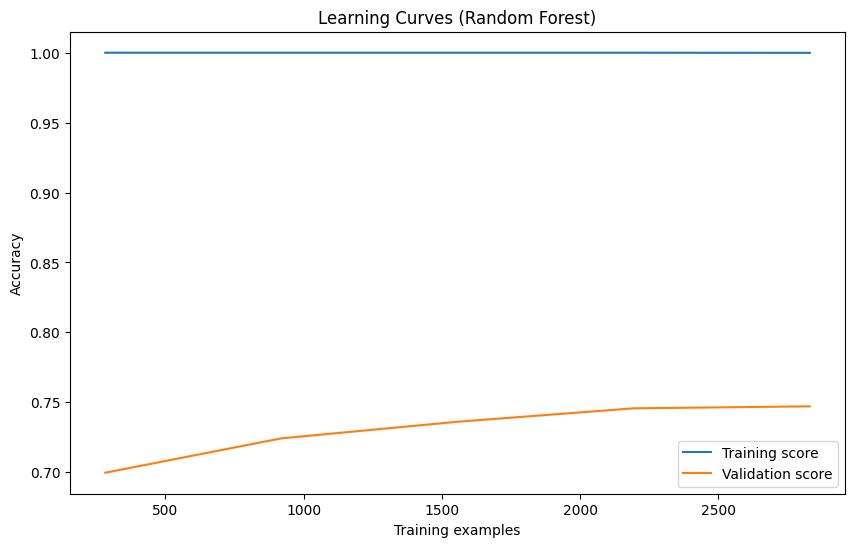

In [18]:
# Create learning curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


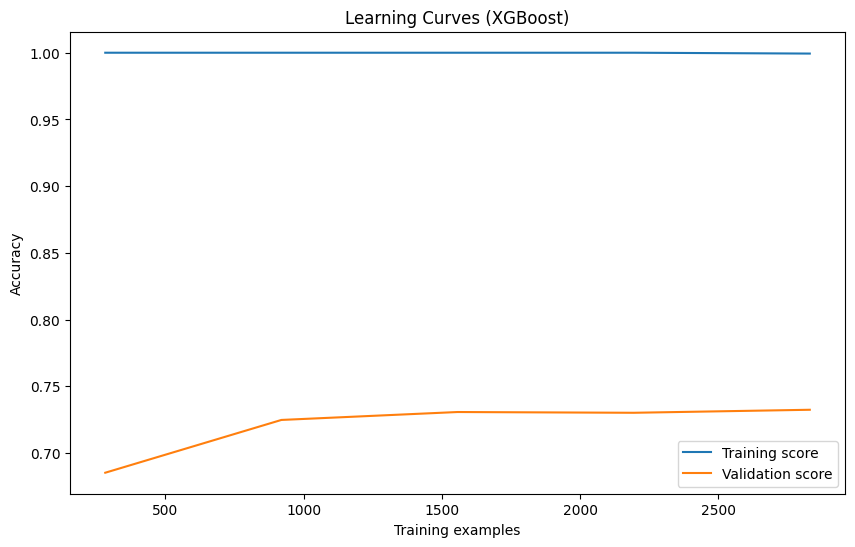

In [19]:
# Create learning curves for XGBoost
train_sizes, train_scores, test_scores = learning_curve(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (XGBoost)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
rf_random_search.fit(X, y_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Previous qualification (grade)', 'Admission grade',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular u...
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP'],
      dtype='object'))])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [None, 5, 10, 15],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=1)

In [21]:
# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    joblib.dump(label_encoder, f)

# Save the Random Forest pipeline
joblib.dump(rf_random_search.best_estimator_, 'rf_pipeline.pkl')

print("Random Forest pipeline and LabelEncoder saved successfully!")

Random Forest pipeline and LabelEncoder saved successfully!


In [22]:
X.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nationality', 'Mother_qualification',
       'Father_qualification', 'Mother_occupation', 'Father_occupation',
       'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
  

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          